# CHEM277B Homework 11
### Trevor Oldham


In [1]:
import numpy as np
import torch


### Process the MNIST data into np arrays

In [23]:
import pandas as pd

training_set, validation_set = pd.read_pickle('mnist.pkl')

#normalized the training data and reshape to shape (ndata, nfeatures)
normalized_train_set = tuple([z / 255 for z in training_set])
normalized_train_set_x = np.array(normalized_train_set[0])
normalized_train_set_x = normalized_train_set_x.reshape(60000, 1024)
print(normalized_train_set_x.shape)

train_set_y = np.array(training_set[1])
#print(normalized_train_set_y.shape)

#normalized the test data and reshape to shape (ndata, nfeatures)
normalized_test_set = tuple([z / 255 for z in validation_set])
normalized_test_set_x = np.array(normalized_test_set[0])
normalized_test_set_x = normalized_test_set_x.reshape(10000, 1024)
print(normalized_test_set_x.shape)

test_set_y = np.array(validation_set[1])

(60000, 1024)
(10000, 1024)


### Define Variational Autoencoder Model

In [2]:
from torch import nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def bottleneck(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps * std + mu # return z sampled
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.bottleneck(mu, log_var)
        return self.decoder(z), mu, log_var



In [6]:
vae = VAE(1024, 256, 128, 32)
print(vae)

VAE(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc31): Linear(in_features=128, out_features=32, bias=True)
  (fc32): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=1024, bias=True)
)


### Define Loss Function using Binary Cross Entropy Loss and KL Divergence

In [5]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Define timing **decorator** and helper functions

In [8]:

from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [42]:
def reconstruct(vae,data_gen):
    """given a VAE model, plot original data and reconstructed data from VAE"""
    inp = next(data_gen)[0]
    #print('Original Data:')
    #plot_digits(inp)
    with torch.no_grad():
        reconst,mu,log_var = vae(torch.tensor(inp,dtype=torch.float))

    #print('Reconstructed Data:')
    #plot_digits(reconst.detach().numpy()) 
    
def plot_digits(data):
    #plot 100 digit. data shape(100,32,32)
    fig, ax = plt.subplots(10, 10, figsize=(12, 12),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
        im.set_clim(0, 1)

### Define Trainer Class and Train/Validate function

In [48]:
import matplotlib.pyplot as plt
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def data_gen(X,y, batchsize):
    '''
    Generator for data
    '''
    for i in range(len(X)//batchsize):
        yield X[i*batchsize:(i+1)*batchsize],y[i*batchsize:(i+1)*batchsize]
    i+=1
    yield X[i*batchsize:],y[i*batchsize:]
        

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
        elif optimizer_type == 'adam_l2':
            self.optimizer = Adam(model.parameters(), learning_rate, weight_decay=1e-5)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,draw_curve=False,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        """
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
        outputs = torch.tensor(outputs, dtype=torch.int64)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float))
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64)

        losses = []
        val_losses = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            #shuffle the data in each epoch
            idx =torch.randperm(inputs.size()[0])
            inputs=inputs[idx]
            outputs=outputs[idx]
            train_gen = data_gen(inputs,outputs,self.batch_size)
            
            epoch_loss = 0

            for batch_input,batch_output in train_gen:
                batch_importance = len(batch_output) / len(outputs)
                batch_predictions, mu, logvar = self.model(batch_input)
                loss = loss_fn(batch_predictions, batch_input, mu, logvar)
                if l2:
                    l2_lambda = 1e-5
                    l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.detach().cpu().item() /self.batch_size * batch_importance
                
            val_loss = self.evaluate(val_inputs, val_outputs, print_loss=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f " % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f" % (val_loss))
            losses.append(epoch_loss)
            val_losses.append(val_loss)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1,losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1,val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
        
        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses,  "val_losses": val_losses}
        
    def evaluate(self, inputs, outputs, print_loss=True):
        if torch.is_tensor(inputs):
            inputs = self.input_transform(inputs)
        else:
            inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
            outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        gen = data_gen(inputs,outputs,self.batch_size)
        losses = 0

        for batch_input,batch_output in gen:
            batch_importance = len(batch_output) / len(outputs)
            with torch.no_grad():
                batch_predictions, mu, logvar = self.model(batch_input)
                loss = loss_fn(batch_predictions, batch_input, mu, logvar)

            
            losses += loss.detach().cpu().item()/self.batch_size * batch_importance

        if print_loss:
            print("Loss: %.3f" % losses)
        return losses

In [27]:
from sklearn.model_selection import train_test_split, KFold
from torchsummary import summary
def train_model(model,Xs,ys,test_Xs,test_ys,epochs,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=1e-3,l2=False,input_shape=(-1,1,32,32)):
    train_Xs, val_Xs, train_ys, val_ys = train_test_split(Xs, ys, test_size=1/3, random_state=0)
    model=model
    summary(model,input_shape[1:])

    print(f"{model} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
            
    trainer = Trainer(model, optimizer, lr, epochs, batchsize, lambda x: x.reshape(input_shape))
    log=trainer.train(train_Xs, train_ys,val_Xs,val_ys,early_stop=early_stop,l2=l2)

    if draw_curve:
        plt.figure()
        plt.plot(log["losses"], label="losses")
        plt.plot(log["val_losses"], label="validation_losses")
        plt.legend()
        plt.title(f'loss')

    # Report result for this fold
    if early_stop:
        report_idx= np.argmin(log["val_losses"])      
    else:
        report_idx=-1
    test_loss=trainer.evaluate(test_Xs,test_ys,print_loss=False)
    print("Test loss:",test_loss)
    return model

### Test the VAE model on MNIST training and test data

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         262,400
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 32]           4,128
            Linear-4                   [-1, 32]           4,128
            Linear-5                  [-1, 128]           4,224
            Linear-6                  [-1, 256]          33,024
            Linear-7                 [-1, 1024]         263,168
Total params: 603,968
Trainable params: 603,968
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.30
Estimated Total Size (MB): 2.32
----------------------------------------------------------------
VAE(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_f

 10%|█         | 1/10 [00:11<01:40, 11.14s/it]

Epoch 1/10 - Loss: 128.490 
              Val_loss: 112.476


func:'train'  took: 89.7847 sec
Test loss: 76.08635925445559


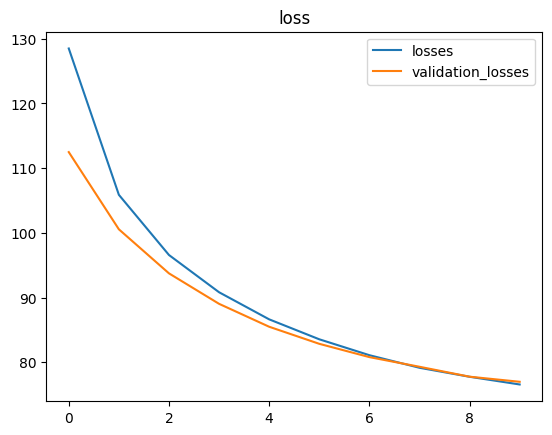

In [49]:
#normalized_train_set_x= normalized_train_set_x.reshape(-1, 1, 32, 32)
#normalized_test_set_x = normalized_test_set_x.reshape(-1, 1, 32, 32)

output = train_model(vae, Xs = normalized_train_set_x, ys = train_set_y, test_Xs = normalized_test_set_x, test_ys = test_set_y, epochs = 10, draw_curve = True, early_stop = False, batchsize=128, optimizer = 'adam', lr=1e-3, input_shape = (-1, 1024))


In [50]:
def reconstruct_plot(vae,data_gen):
    """given a VAE model, plot original data and reconstructed data from VAE"""
    inp = next(data_gen)[0]
    print('Original Data:')
    plot_digits(inp)
    with torch.no_grad():
        reconst,mu,log_var = vae(torch.tensor(inp,dtype=torch.float))

    print('Reconstructed Data:')
    plot_digits(reconst.detach().numpy())

### Examine reconstructed images from test set of MNIST images

Original Data:
Reconstructed Data:


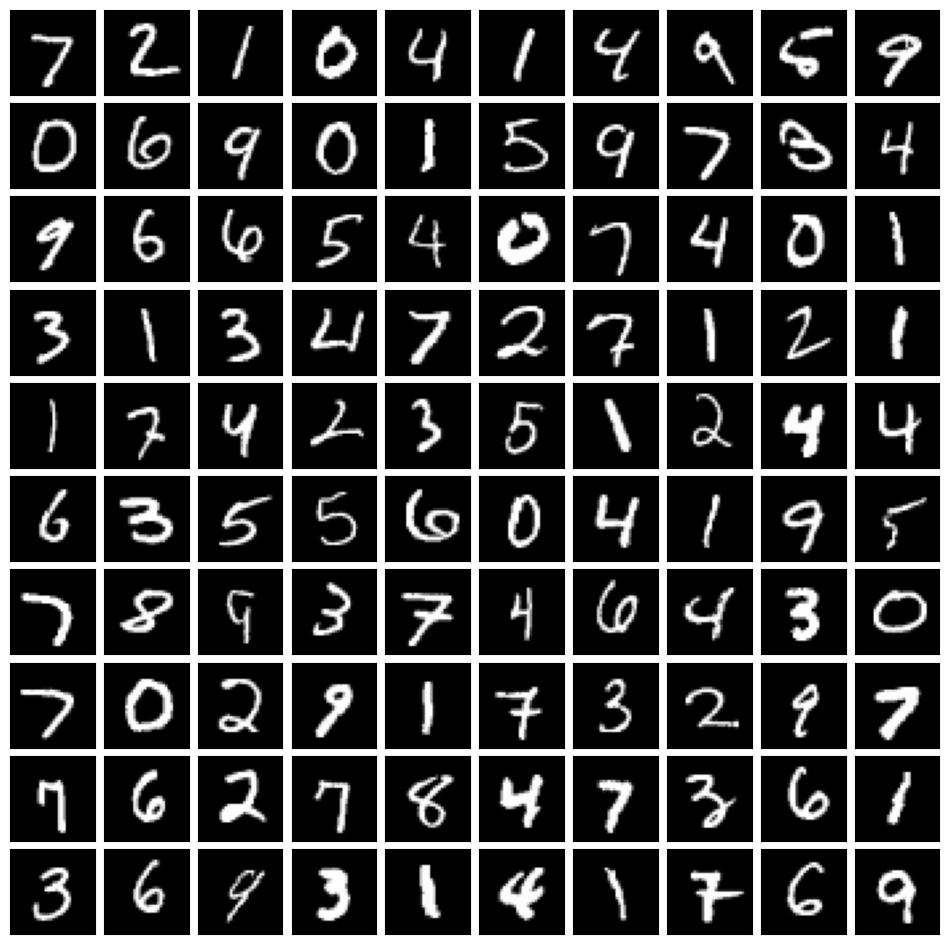

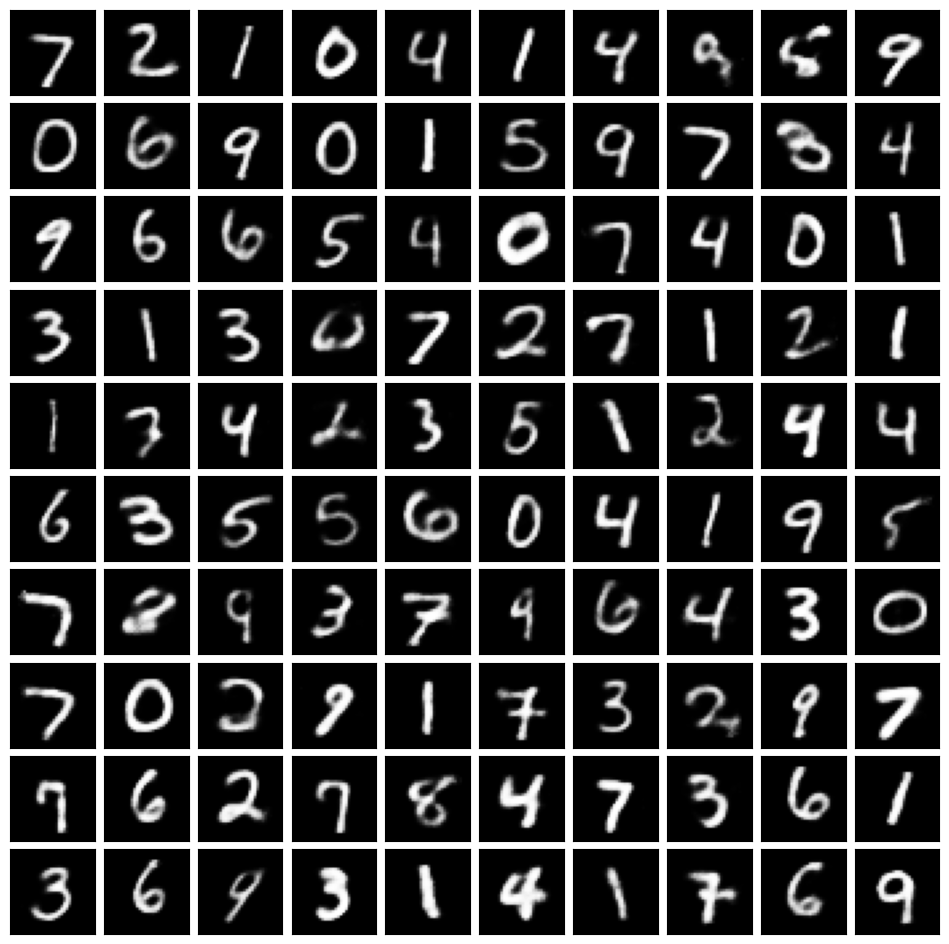

In [59]:
image = data_gen(normalized_test_set_x[0:100][:], test_set_y[0:100][:], 100)
#print(normalized_test_set_x[0:10][:].shape)
reconstruct_plot(vae, image)

Overall the model does improve over training and reaches a minimum around the end of 10 epochs. The training and validation curves minimize the Binary Cross Entropy loss during training, and the model is used to demnstrate that the reconstructed images are very similar to the images used as input to the model.